# 평가 조건
1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?
    - 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?
    - 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?
    - 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.

In [1]:
!pip install --upgrade gensim==3.8.3

# 1. 모듈 임포트

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim
from konlpy.tag import Mecab
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import pickle
import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(gensim.__version__)

3.8.3


# 2. 데이터 불러오기
데이터는 Q, A, label 3개의 열로 이루어져 있습니다. label 데이터는 필요없으므로 삭제하도록 하겠습니다.

In [3]:
chatbot_file_path=os.getenv('HOME') + '/aiffel/going_deeper/data/ChatbotData.csv'

data = pd.read_csv(chatbot_file_path, encoding = 'utf-8')
data.drop(labels='label', axis = 1, inplace = True)
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


In [5]:
print('데이터 수:',len(data))

데이터 수: 11823


# 3. 데이터 전처리

## 3-1. 중복 처리

In [6]:
data.drop_duplicates(inplace=True)
print('중복을 제거한 데이터 수:',len(data))

중복을 제거한 데이터 수: 11750


질문과 답변이 모두 겹치는 73개의 데이터를 제외하고, 11,750개의 데이터를 사용하도록 하겠습니다.

## 3-2. 단어정제 함수

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #문장 내의 구둣점옆에 공백 추가
    sentence = re.sub(r'[^a-zA-Z가-힣0-9?.!, ]+', r' ', sentence) #영문 알파벳, 한글, 숫자, 구둣점을 제외한 모든 문자를 제거
    sentence = re.sub(r'[" "]+', " ", sentence) #연속된 공백을 하나의 공백으로 변환

    return sentence

# 4. 데이터 토큰화

In [8]:
def make_corpus(data):
    
    mecab = Mecab()
    
    #단어 정제
    data['Q'] = data['Q'].apply(preprocess_sentence)
    data['A'] = data['A'].apply(preprocess_sentence)
    
    que_corpus = []
    
    for i in tqdm(data['Q']):
        que_corpus.append(mecab.morphs(i))
    
    ans_corpus = []
    
    for i in tqdm(data['A']):
        ans_corpus.append(mecab.morphs(i))
    
    
    return que_corpus, ans_corpus

In [9]:
#토큰화된 데이터
que_corpus, ans_corpus = make_corpus(data)

  0%|          | 0/11750 [00:00<?, ?it/s]

  0%|          | 0/11750 [00:00<?, ?it/s]

In [10]:
#데이터 확인
display(que_corpus[:5])
display(ans_corpus[:5])

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네']]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.']]

## 4-1. 데이터 길이 확인

In [11]:
def data_lens(data, name):
    
    print('{} 데이터의 최소 길이 :{}'.format(name, min(len(l) for l in data)))
    print('{} 데이터의 최대 길이 :{}'.format(name, max(len(l) for l in data)))
    print('{} 데이터의 평균 길이 :{}'.format(name, sum(map(len, data))/len(data)))

    plt.hist([len(s) for s in data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

질문 데이터의 최소 길이 :1
질문 데이터의 최대 길이 :32
질문 데이터의 평균 길이 :7.028340425531915


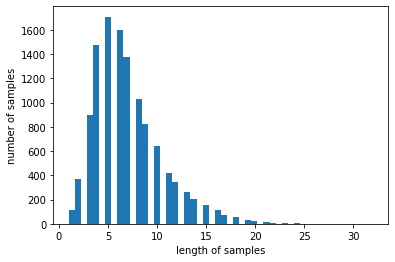

In [12]:
data_lens(que_corpus, '질문')

답변 데이터의 최소 길이 :1
답변 데이터의 최대 길이 :40
답변 데이터의 평균 길이 :8.376170212765958


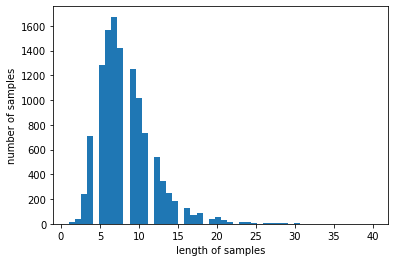

In [13]:
data_lens(ans_corpus, '답변')

추후 데이터의 길이는 스페셜 토큰을 추가하고, 최대 42로 설정하여 padding을 해주도록 하겠습니다.

## 4-2. 테스트 데이터 만들기

In [20]:
#데이터 섞기
paired_data = list(zip(que_corpus, ans_corpus))
random.shuffle(paired_data)
que_corpus1, ans_corpus1 = zip(*paired_data)

In [21]:
#데이터 확인
display(que_corpus[:5])
display(ans_corpus[:5])
print('-'*50)
display(que_corpus1[:5])
display(ans_corpus1[:5])

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네']]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.']]

--------------------------------------------------


(['어제', '밤', '샜', '어'],
 ['남', '사친', '이랑', '사귀', '는', '거', '가능', '?'],
 ['너무', '잘', '하', '는', '후배', '가', '들어왔', '어'],
 ['아무리', '열심히', '해도', '선천', '적', '인', '건', '못', '따라가', '겠', '지', '?'],
 ['또', '어떻게', '버티', '지', '?'])

(['건강', '에', '안', '좋', '아요', '.'],
 ['가능', '해요', '.'],
 ['배울', '점', '은', '배우', '세요', '.'],
 ['다른', '걸', '발전', '시켜', '보', '세요', '.'],
 ['내일', '은', '나', '을', '거', '예요', '.'])

In [22]:
train_que_corpus = list(que_corpus1[:-100])
test_que_corpus = list(que_corpus1[-100:])

In [23]:
train_ans_corpus = list(ans_corpus1[:-100])
test_ans_corpus = list(ans_corpus1[-100:])

In [24]:
print('질문 훈련 데이터 사이즈:',len(train_que_corpus))
print('답변 훈련 데이터 사이즈:',len(train_ans_corpus))
print('-'*50)
print('질문 테스트 데이터 사이즈:',len(test_que_corpus))
print('질문 테스트 데이터 사이즈:',len(test_ans_corpus))

질문 훈련 데이터 사이즈: 11650
답변 훈련 데이터 사이즈: 11650
--------------------------------------------------
질문 테스트 데이터 사이즈: 100
질문 테스트 데이터 사이즈: 100


# 5. 데이터 증강

## 5-1. 한국어 Word2Vec 불러오기
한국어로 사전훈련된 Embedding 모델을 불러옵니다.

In [25]:
model_path=os.getenv('HOME') + '/data/ko.bin'

w2v = gensim.models.Word2Vec.load(model_path)

In [26]:
w2v.most_similar("엄마")

/tmp/ipykernel_496/1209007476.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("엄마")


[('아빠', 0.8578546643257141),
 ('아가씨', 0.7076528072357178),
 ('하녀', 0.7051166892051697),
 ('언니', 0.7047619223594666),
 ('친구', 0.7044110298156738),
 ('아저씨', 0.7022912502288818),
 ('강아지', 0.6934334635734558),
 ('할머니', 0.663257360458374),
 ('아기', 0.6483575701713562),
 ('아내', 0.648257851600647)]

In [27]:
w2v.most_similar("성공")

/tmp/ipykernel_496/1041525889.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("성공")


[('실패', 0.6856883764266968),
 ('대성공', 0.6117161512374878),
 ('주력', 0.5659711360931396),
 ('압승', 0.5545106530189514),
 ('흥행', 0.49906763434410095),
 ('공헌', 0.4934632182121277),
 ('성공적', 0.48284801840782166),
 ('승리', 0.46511217951774597),
 ('진력', 0.4633210301399231),
 ('그치', 0.4610019326210022)]

## 5-2. 데이터 증강 함수
- 증강 함수를 구현하였습니다.
1. 먼저 토큰화된 단어를 받습니다.
2. 그 중 랜덤으로 하나의 단어를 선택합니다.
3. threshold를 기준으로 대처어들중 랜덤으로 교체합니다.
4. threshold를 넘는 단어가 없다면, 최상위 유사어로 교체합니다.
5. 단어장에 없는 단어는 기존에 선택된 단어를 그대로 반영합니다.

In [28]:
def lexical_sub(sentence, word2vec, threshold = None):
    mecab = Mecab()
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        similar_words = word2vec.most_similar(_from)

        if _from == '.' or _from == '!' or _from == '?':
            _to = _from
        elif similar_words[0][1] >= threshold:
            candidates = [word[0] for word in similar_words if word[1] >= threshold]
            _to = random.choice(candidates)
        else:
            _to = similar_words[0][0]

    except:   # 단어장에 없는 단어는 원래 증강 시키려고 했던 단어를 그대로 반영
        _to = _from
        
    for tok in toks:
        if tok == _from:
            res += _to + " "
        else:
            res += tok + " "
    
    return mecab.morphs(res)

In [29]:
def Data_Augmentation(old_data, model, threshold):
    new_data = []
    
    for old_src in tqdm(old_data):
        new_src = lexical_sub(old_src, model, threshold=threshold)
        new_data.append(new_src)
    
    return new_data

In [30]:
aug_que_data1 = Data_Augmentation(train_que_corpus, w2v, 0.55)
aug_ans_data1 = Data_Augmentation(train_ans_corpus, w2v, 0.55)

  0%|          | 0/11650 [00:00<?, ?it/s]

/tmp/ipykernel_496/2910868040.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = word2vec.most_similar(_from)


  0%|          | 0/11650 [00:00<?, ?it/s]

In [31]:
print('<기존 데이터>')
display(train_que_corpus[:5])
display(train_ans_corpus[:5])
print('='*50)
print('<증강 데이터>')
display(aug_que_data1[:5])
display(aug_ans_data1[:5])

<기존 데이터>


[['어제', '밤', '샜', '어'],
 ['남', '사친', '이랑', '사귀', '는', '거', '가능', '?'],
 ['너무', '잘', '하', '는', '후배', '가', '들어왔', '어'],
 ['아무리', '열심히', '해도', '선천', '적', '인', '건', '못', '따라가', '겠', '지', '?'],
 ['또', '어떻게', '버티', '지', '?']]

[['건강', '에', '안', '좋', '아요', '.'],
 ['가능', '해요', '.'],
 ['배울', '점', '은', '배우', '세요', '.'],
 ['다른', '걸', '발전', '시켜', '보', '세요', '.'],
 ['내일', '은', '나', '을', '거', '예요', '.']]

<증강 데이터>


[['어제', '밤', '샜', '어'],
 ['남', '사친', '이랑', '사귀', 'ㄴ', '다는', '거', '가능', '?'],
 ['너무', '잘', '하', '는', '선배', '가', '들어왔', '어'],
 ['아무리', '열심히', '해도', '선천', '적', '인', '건', '못', '떠나', '겠', '지', '?'],
 ['또', '언제', '버티', '지', '?']]

[['건강', '에', '안', '좋', '아요', '.'],
 ['가능', '해요', '.'],
 ['배울', '점', '은', '배우', '세요', '.'],
 ['다른', '걸', '발전', '시켜', '찾아보', '세요', '.'],
 ['내일', '은', '나', '을', '것', '예요', '.']]

In [32]:
aug_que_data2 = Data_Augmentation(train_que_corpus, w2v, 0.55)
aug_ans_data2 = Data_Augmentation(train_ans_corpus, w2v, 0.55)

  0%|          | 0/11650 [00:00<?, ?it/s]

/tmp/ipykernel_496/2910868040.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = word2vec.most_similar(_from)


  0%|          | 0/11650 [00:00<?, ?it/s]

In [33]:
print('<기존 데이터>')
display(train_que_corpus[:5])
display(train_ans_corpus[:5])
print('='*50)
print('<증강 데이터>')
display(aug_que_data2[:5])
display(aug_ans_data2[:5])

<기존 데이터>


[['어제', '밤', '샜', '어'],
 ['남', '사친', '이랑', '사귀', '는', '거', '가능', '?'],
 ['너무', '잘', '하', '는', '후배', '가', '들어왔', '어'],
 ['아무리', '열심히', '해도', '선천', '적', '인', '건', '못', '따라가', '겠', '지', '?'],
 ['또', '어떻게', '버티', '지', '?']]

[['건강', '에', '안', '좋', '아요', '.'],
 ['가능', '해요', '.'],
 ['배울', '점', '은', '배우', '세요', '.'],
 ['다른', '걸', '발전', '시켜', '보', '세요', '.'],
 ['내일', '은', '나', '을', '거', '예요', '.']]

<증강 데이터>


[['어제', '밤', '샜', '어서'],
 ['남', '사친', '이랑', '갈등', '하', '는', '거', '가능', '?'],
 ['너무', '잘', '하', '는', '교사', '가', '들어왔', '어'],
 ['아무리', '열심히', '해도', '선천', '적', '인', '건', '못', '따라가', '싶', '지', '?'],
 ['또', '어떻게', '걸어다니', '지', '?']]

[['건강', '에', '안', '좋', '아요', '.'],
 ['사용', '가능', '해요', '.'],
 ['배울', '점', '은', '익히', '세요', '.'],
 ['다른', '걸', '발전', '시켜', '보', 'ㅂ시다', '.'],
 ['내일', '은', '데', '나', '을', '거', '예요', '.']]

증강은 되었지만, 그렇게 만족스러운 증강이라고는 생각되지 않습니다.

# 6. 토크나이저 & 데이터 벡터화

In [34]:
print('<질문 데이터>')
print('기존데이터:',len(train_que_corpus))
print('첫번째 증강 데이터:',len(aug_que_data1))
print('두번째 증강 데이터:',len(aug_que_data2))
print('='*50)
print('<답변 데이터>')
print('기존데이터:',len(train_ans_corpus))
print('첫번째 증강 데이터:',len(aug_ans_data1))
print('두번째 증강 데이터:',len(aug_ans_data2))
print('='*50)
print('총 질문 데이터의 수:',len(train_que_corpus)+len(aug_que_data1)+len(aug_que_data2))
print('총 답변 데이터의 수:',len(train_ans_corpus)+len(aug_ans_data1)+len(aug_ans_data2))

<질문 데이터>
기존데이터: 11650
첫번째 증강 데이터: 11650
두번째 증강 데이터: 11650
<답변 데이터>
기존데이터: 11650
첫번째 증강 데이터: 11650
두번째 증강 데이터: 11650
총 질문 데이터의 수: 34950
총 답변 데이터의 수: 34950


증강을 통하여 질문, 답변 총 34950개의 데이터를 확보하였습니다.

단어 사전을 만들어서 벡터화를 시켜주도록 하겠습니다.

In [35]:
que_data = train_que_corpus + aug_que_data1 + aug_que_data2
ans_data = train_ans_corpus + aug_ans_data1 + aug_ans_data2

In [36]:
tgt_data = []

for corpus in tqdm(ans_data):
    tgt_data.append(["<start>"] + corpus + ["<end>"])

  0%|          | 0/34950 [00:00<?, ?it/s]

In [37]:
tgt_data[:3]

[['<start>', '건강', '에', '안', '좋', '아요', '.', '<end>'],
 ['<start>', '가능', '해요', '.', '<end>'],
 ['<start>', '배울', '점', '은', '배우', '세요', '.', '<end>']]

In [38]:
def tokenizer(question_data, answer_data, vocab_size=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<unk>",
        num_words=vocab_size
    )
    
    corpus = question_data + answer_data 
            
    tokenizer.fit_on_texts(corpus)
            
    index_to_word = {}
    word_to_index = {}    
    
    for word, index in tqdm(tokenizer.word_index.items()):
        index_to_word.update({index:word})
        word_to_index.update({word:index})    
    
    return tokenizer, index_to_word, word_to_index

In [39]:
tokenizer,index_to_word, word_to_index = tokenizer(que_data, tgt_data)

  0%|          | 0/9290 [00:00<?, ?it/s]

In [40]:
VOCAB_SIZE = len(word_to_index)+1

단어 사전의 수는 총 9291개 입니다.

In [41]:
def make_corpus(sentences, tokenizer):
    tokens = tokenizer.texts_to_sequences(sentences)

    return tokens

In [42]:
questions_data = make_corpus(que_data, tokenizer)
answers_data = make_corpus(tgt_data, tokenizer)

In [43]:
print(que_data[0])
print(questions_data[0])
print('\n')
print(tgt_data[0])
print(answers_data[0])

['어제', '밤', '샜', '어']
[417, 612, 3770, 11]


['<start>', '건강', '에', '안', '좋', '아요', '.', '<end>']
[3, 429, 25, 43, 13, 48, 2, 4]


In [44]:
MAX_LEN = 42
questions_ = tf.keras.preprocessing.sequence.pad_sequences(questions_data, maxlen=MAX_LEN, padding='post')
answers_ = tf.keras.preprocessing.sequence.pad_sequences(answers_data, maxlen=MAX_LEN, padding='post')

In [45]:
print(questions_.shape)
print(answers_.shape)

(34950, 42)
(34950, 42)


In [46]:
np.isnan(questions_).sum()

0

In [47]:
np.isnan(answers_).sum()

0

# 7. 트랜스포머 구현 및 훈련

## positional_encoding

In [56]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

## MultiHeadAttention

In [57]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        QK = tf.matmul(Q,K, transpose_b = True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        attentions = tf.nn.softmax(scaled_qk, axis = -1)
        out = tf.matmul(attentions, V)
        
        
        return out, attentions
        

    def split_heads(self, x):

        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])
        
        
        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
      
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

## PoswiseFeedForwardNet

In [58]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## Encoder & Decoder

In [59]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [60]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [61]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer

In [62]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [63]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

## 학습 옵티마이저

In [64]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=256,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=42,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

d_model = 128

In [65]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps= 1500):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [66]:
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [67]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 학습 함수

In [68]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [69]:
BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, questions_.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                    train_step(questions_[idx:idx+BATCH_SIZE],
                                answers_[idx:idx+BATCH_SIZE],
                                transformer,
                                optimizer)
    
#         if not np.isfinite(batch_loss):  # NaN 값인지 확인
#             print(f"NaN value in batch {batch} at index {idx}")
#             # 배치의 데이터 확인
#             print("Questions batch:", questions_[idx:idx+BATCH_SIZE])
#             print("Answers batch:", answers_[idx:idx+BATCH_SIZE])
#             break
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss / (batch + 1)))
    
#     if not np.isfinite(total_loss / (batch + 1)):
#         break

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

# 8. 성능 평가하기
## 8-1. BLEU Score
BLEU(Bilingual Evaluation Understudy)는 기계 번역 성능을 측정하기 위한 평가 지표 중 하나

BLEU는 번역된 문장과 사람이 작성한 참조 번역문 사이의 유사성을 측정하여 번역 품질을 평가

BLEU 점수는 0부터 1까지의 값으로 나타나며, 높을수록 번역 품질이 더 좋다고 판단

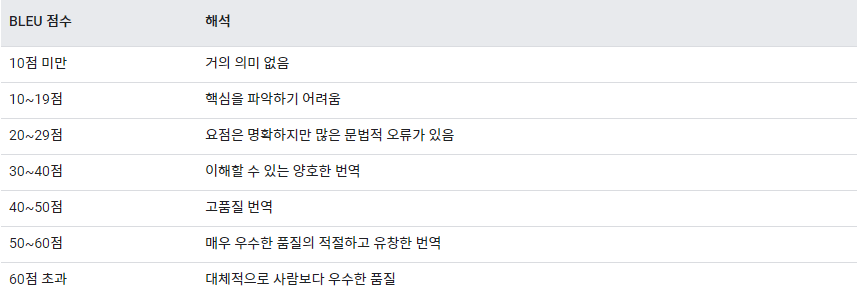

In [70]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer):
    mecab = Mecab()
    
    sentence = mecab.morphs(sentence)
    _input = src_tokenizer.texts_to_sequences([sentence])
    
    sos_idx = tgt_tokenizer.word_index['<start>']
    eos_idx = tgt_tokenizer.word_index['<end>']
    
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(_input,
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([sos_idx], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if eos_idx == predicted_id:
            result = tgt_tokenizer.sequences_to_texts([ids])  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.sequences_to_texts([ids])  
    return result

In [72]:
examples = ['지루하다, 놀러가고 싶어.',
'오늘 일찍 일어났더니 피곤하다.',
'간만에 여자친구랑 데이트 하기로 했어.',
'집에 있는다는 소리야.']

for sentence in examples:
    prediction_answers = translate(sentence, transformer, tokenizer, tokenizer)
    print('질문:{}   -->   답변:{}'.format(sentence, prediction_answers))

질문:지루하다, 놀러가고 싶어.   -->   답변:['마음 이 에 따라 얼마 든지 바뀔 수 있 어요 .']
질문:오늘 일찍 일어났더니 피곤하다.   -->   답변:['이제 좀 괜찮 아 졌 길 바랍니다 .']
질문:간만에 여자친구랑 데이트 하기로 했어.   -->   답변:['도전 은 기분 전환 되 고 많 아요 .']
질문:집에 있는다는 소리야.   -->   답변:['자주 내 집 에 요 .']


썩 좋은 답변은 생성해내지 못하는 것으로 생각됩니다.

In [73]:
translate('힘든 과제였어.', transformer, tokenizer, tokenizer)

['잊 을 수 있 었 을 거 예요 .']

In [75]:
translate('성공하고 싶어.', transformer, tokenizer, tokenizer)

['지금 보다 더 잘 살 거 예요 .']

테스트를 해보니, 질문과 관련된 답변은 만들어내는 것으로 생각됩니다.

In [76]:
def restore_sentence(tokens):
    sentence = " ".join(tokens)
    return sentence

In [77]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):

    reference = restore_sentence(tgt_sentence)
    candidate = translate(restore_sentence(src_sentence), model, src_tokenizer, tgt_tokenizer)
    candidate = " ".join(candidate)
    
    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", restore_sentence(src_sentence))
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [78]:
test_idx = 7

eval_bleu_single(transformer, 
                 test_que_corpus[test_idx], 
                 test_ans_corpus[test_idx], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  오늘 도 짝사랑 하 는 여자 땜 에 술 마시 는 중 .
Model Prediction:  짝사랑 의 늪 에서 벗어나 세요 .
Real:  술 한잔 으로 잊혀질 수 있 다면 얼마나 좋 을까요 .
Score: 0.041139



0.04113945566994292

In [79]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [80]:
eval_bleu(transformer, test_que_corpus, test_ans_corpus, tokenizer, tokenizer, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Num of Sample: 100
Total Score: 0.1828275210876303


테스트 데이터의 BLEU Score의 평균 점수는 약 18점입니다.

## 8-2. Beam Search Decoder를 통하여 답변 만들기

In [81]:
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [82]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    sentence = restore_sentence(sentence)
    
    tokens = src_tokenizer.texts_to_sequences(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                            maxlen=src_len,
                                                            padding='post')
    
    sos_idx = tgt_tokenizer.word_index['<start>']
    eos_idx = tgt_tokenizer.word_index['<end>']

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = sos_idx

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == eos_idx:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(eos_idx)
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

In [83]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    
    reference = restore_sentence(reference)
    candidate = " ".join(candidate)
    
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

In [84]:
def beam_bleu(reference, ids, tokenizer):
    reference = restore_sentence(reference)

    total_score = 0.0
    
    print('질문:', restore_sentence(test_que_corpus[test_idx]))
    print('\n')
    for _id in ids:
        candidate = tokenizer.sequences_to_texts([_id.tolist()])
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

In [97]:
test_idx = 33
ids = \
beam_search_decoder(test_que_corpus[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_ans_corpus[test_idx], ids, tokenizer)
print('\n')
print(bleu)

질문: 내 가 썸 깼 는데 다시 연락 하 고 싶 어 .


Reference: 감정 에 확신 이 있 다면 연락 해 보 세요 .
Candidate: ['<start> 괜한 기대 세요 . <end>']
BLEU: 0.01011174839966176
Reference: 감정 에 확신 이 있 다면 연락 해 보 세요 .
Candidate: ['<start> 너무 기대 세요 . <end>']
BLEU: 0.01011174839966176
Reference: 감정 에 확신 이 있 다면 연락 해 보 세요 .
Candidate: ['<start> 괜한 기대 는 . <end>']
BLEU: 0.006823096835908585
Reference: 감정 에 확신 이 있 다면 연락 해 보 세요 .
Candidate: ['<start> 너무 기대 는 . <end>']
BLEU: 0.006823096835908585
Reference: 감정 에 확신 이 있 다면 연락 해 보 세요 .
Candidate: ['<start> 바라 기대 세요 . <end>']
BLEU: 0.01011174839966176


0.008796287774160489


# 9. 결과

|하이퍼파라미터| value|
|--------|----------|
|n_layers|2|
|d_model|128|
|n_heads|8|
|d_ff|256|
|vocab_size|9291|
|pos_len|42|
|dropout|0.2|
|BATCH_SIZE|64|
|EPOCHS|10|


|  No  | 질문 | 답변 |생성된 답변|
|------|------|------|------|
|1|지루하다, 놀러가고 싶어.|잠깐 쉬 어도 돼요 .|'마음 이 에 따라 얼마 든지 바뀔 수 있 어요 .'|
|2|오늘 일찍 일어났더니 피곤하다.|맛난 거 드세요 .|__이제 좀 괜찮 아 졌 길 바랍니다 .__|
|3|간만에 여자친구랑 데이트 하기로 했어. |떨리 겠 죠 .|도전 은 기분 전환 되 고 많 아요 .|
|4|집에 있는다는 소리야.|좋 아 하 면 그럴 수 있 어요 .|자주 내 집 에 요 .|
|5|힘든 과제였어|-|잊 을 수 있 었 을 거 예요 .|
|6|성공하고 싶어.|-|__지금 보다 더 잘 살 거 예요 .__|
|7|오늘 도 짝사랑 하 는 여자 땜 에 술 마시 는 중 .|술 한잔 으로 잊혀질 수 있 다면 얼마나 좋 을까요 .|__짝사랑 의 늪 에서 벗어나 세요 .__|
|8|내 가 썸 깼 는데 다시 연락 하 고 싶 어 .|감정 에 확신 이 있 다면 연락 해 보 세요 .|__괜한 기대 세요 .__|


챗봇은 질문이 들어왔을때, 질문에 관련된 답변을 잘해내는 것이 중요합니다. 생성된 답변을 보면 생각보다 질문에 관련된 답변을 잘 만들어낸것을 확인할 수 있습니다.

# 전체 회고

- 전체적으로 쉬우면서도 어려웠던 과제였던것 같습니다.
- 위의 표를 보면 질문에 관련된 답변을 잘 생성해낸 것을 확인할 수 있습니다.
- BLEU Score를 통하여 성능평가를 해보았지만 점수가 낮은 것을 확인할 수 있습니다. 하지만 챗봇의 경우는 BLEU Score로 평가하는것이 의미가 없다고 생각됩니다. 챗봇에는 답변이란것이 정해져있는것이 아니고 질문과 얼마나 관련된 대답을 할 수 있냐가 중요하기 때문입니다.

- 이번과제에서는 증강을 통하여 데이터를 늘려주었는데, 역시 증강의 품질을 좋지 못했다고 생각이 됩니다.
- 증강은 품질이 좋았다면, 생성해낸 답변의 퀄리티도 올릴 수 있을거라 생각합니다.

- 또한 이번 과제는 훈련시 loss값이 nan이 되는 trouble이 발생하였습니다.


- 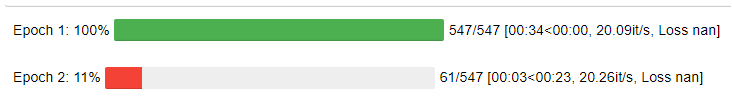


- 해당 trouble이 발생하는 이유는 크게 6가지로 확인할 수 있습니다.
    1. input data에 nan이 존재
    2. 데이터 타입 문제
    3. learningrate가 너무 높은 문제
    4. optimizer 문제
    5. 특성 스케일 방법 문제
    6. 데이터와 outsize가 불일치
    
- 1~6번까지 하나씩 확인해봤지만, 해결하지 못했었습니다. 하지만 vocab_size + 1을 통하여 문제를 해결하였습니다.
- 이는 패딩(padding) 토큰에 관련된 문제라고 생각됩니다.
- 일반적으로 데이터를 전처리할 때, 입력 시퀀스와 출력 시퀀스의 길이를 일정하게 맞추기 위해 패딩 토큰을 사용합니다. 패딩 토큰은 단어가 아니기 때문에 별도의 토큰 인덱스를 할당하는데, 이 인덱스가 일반적인 단어의 범위와 중복될 가능성이 있습니다.
- 패딩 토큰을 위한 별도의 토큰 인덱스를 추가 할당한 것으로 해당 문제를 해결할 수 있었습니다.


- 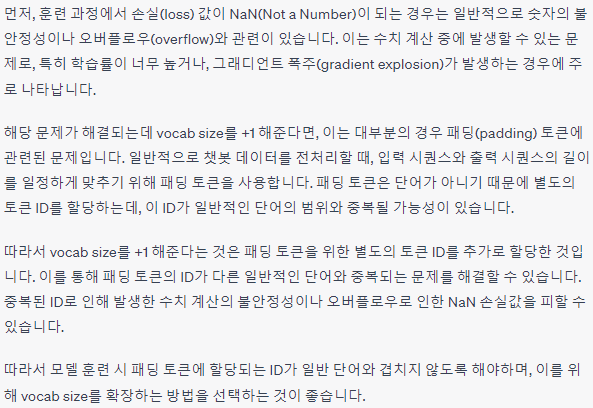


- 아래의 코드는 훈련 loss nan 발생시 확인할 수 있는 코드를 정리해두었습니다.

- 기존의 계획은 한국어 Word2Vec모델과 Korea wordnet의 증강 결과를 비교하면서 진행해보고자 하였는데, 이슈 발생으로 시간을 너무 허비해서 그러지 못했습니다.
- 추후에 한국어 Word2Vec모델과 Korea wordnet의 증강 결과를 비교하고자 합니다.

# 참고 자료
- 이전 노드
- https://bigdaheta.tistory.com/68
- https://velog.io/@seolini43/%ED%8C%8C%EC%9D%B4%EC%8D%ACTransformer%EB%A1%9C-%EC%98%A4%ED%94%BC%EC%8A%A4-%EC%B1%97%EB%B4%87-%EB%A7%8C%EB%93%A4%EA%B8%B0-%EC%BD%94%EB%93%9C

#### 훈련 loss nan 발생시 확인할 수 있는 코드

In [ ]:
batch_idx = 544
data_idx = 34816

questions_batch = questions_[batch_idx * BATCH_SIZE: (batch_idx + 1) * BATCH_SIZE]
answers_batch = answers_[batch_idx * BATCH_SIZE: (batch_idx + 1) * BATCH_SIZE]

question_data = questions_batch[data_idx % BATCH_SIZE]
answer_data = answers_batch[data_idx % BATCH_SIZE]

print("Question:", question_data)
print("Answer:", answer_data)

In [ ]:
def decode_tokens(token_ids, tokenizer):
    # 토큰 ID를 텍스트로 변환
    tokens = tokenizer.sequences_to_texts(token_ids)
    
    # 특수 토큰 및 패딩 제거
    tokens = [token for token in tokens if token != '[PAD]']
    
    # 텍스트로 변환
    text = tokenizer.sequences_to_texts(tokens)
    
    return text

# 디코딩된 토큰을 원래의 텍스트로 변환
decoded_question = decode_tokens(questions_[0], tokenizer)
decoded_answer = decode_tokens(answers_[0], tokenizer)

# 결과 출력
print("Decoded Question:", decoded_question)
print("Decoded Answer:", decoded_answer)

In [ ]:
# 데이터 확인을 위한 코드
def check_data(questions_batch, answers_batch):
    # NumPy 배열을 Pandas DataFrame으로 변환
    questions_df = pd.DataFrame(questions_batch)
    answers_df = pd.DataFrame(answers_batch)

    # 데이터 형태 확인
    print("Questions shape:", questions_df.shape)
    print("Answers shape:", answers_df.shape)

    # NaN 값 확인
    print("NaN values in Questions:", questions_df.isnull().sum().sum())
    print("NaN values in Answers:", answers_df.isnull().sum().sum())

    # NaN 값을 포함한 행 출력
    nan_rows_questions = questions_df[questions_df.isnull().any(axis=1)]
    nan_rows_answers = answers_df[answers_df.isnull().any(axis=1)]

    print("\nQuestions with NaN values:")
    print(nan_rows_questions)
    print("\nAnswers with NaN values:")
    print(nan_rows_answers)

# 데이터 확인
check_data(questions_, answers_)

### wordnet 불러오는 방법

In [ ]:
wordnet_path=os.getenv('HOME') + '/aiffel/going_deeper/data/wordnet.pickle'
with open(wordnet_path, "rb") as f:
    wordnet = pickle.load(f)